In [4]:
import numpy as np
from numpy import dot

from sklearn import datasets as ds  
from sklearn import model_selection as ms

import matplotlib.pyplot as plt 

import math as m 
import random
import copy

# 1.重构一个较为泛用的优化器

In [5]:
#先不考虑batchSGD，所以没epo参数和batches参数
def optimizier(updater,classifier,x_train,y_train,x_validation,y_validation,it_num,amountOfPoints,batches):
    quotient = it_num // amountOfPoints 
    validation_loss = np.linspace(1,20,amountOfPoints+1)
    validation_accur = np.linspace(1,20,amountOfPoints+1)
    x_it_num = np.arange(amountOfPoints+1)
    
    validation_loss[0] = classifier.loss(x_validation,y_validation)
    validation_accur[0] = accuracy(x_validation,y_validation,classifier.parameter)
    j=1
    for i in range(it_num):
        if( (i+1) % quotient == 0 ):
            validation_loss[j] = classifier.loss(x_validation,y_validation)
            validation_accur[j] = accuracy(x_validation,y_validation,classifier.parameter)
            j += 1
        classifier.parameter = \
        updater.updates( classifier.getGrad, classifier.parameter, x_train, y_train, batches )
    return x_it_num,validation_loss,validation_accur
    

# 2.分类器类

In [6]:
class logisticRegression:
    parameter = 0
    
    def __init__(self,W):
        self.parameter = W
########################################################################################   
    def loss(self,x_set,y_set):
        #数据的数量
        amount = x_set.shape[0]
        n_features = x_set.shape[1]
        
        xt = 0
        yt = 0
        loss = 0
        for i in range(amount):
            xt = x_set[i].reshape(n_features,1)
            yt = y_set[i].reshape(1,1)
            loss = loss + \
            m.log( 1 + m.exp( dot( dot( -yt, self.parameter.T ),xt )[0][0] ) )
        loss = loss / amount  + 1/2 * dot( self.parameter.T, self.parameter )[0][0]
        
        return loss
########################################################################################      
    
    def getGrad(self,x_set,y_set,pm,batches):
    #数据的数量
       
        amount = x_set.shape[0]
        n_features = x_set.shape[1]
             #生成的随机数n: 12 <= n <= 20 
        #求导数
        grad = np.zeros((n_features,1))
        for i in range(batches):
            j = random.randint(0, amount-1)
            xt = x_set[j].reshape(n_features,1)
            yt = y_set[j].reshape(1,1)
        
            grad = grad - yt[0][0] * xt / \
            ( 1 + m.exp( dot( dot( yt, pm.T ),xt )[0][0] ) )
        grad = grad / batches + 1 * pm
    #print(i)
        return grad

# 3.优化方法类

In [7]:
class NAG:
    lr = 0
    gamma = 0
    v = 0
    
    def __init__(self,lr=0.001,gamma=0.5):
        self.lr = lr
        self.gamma = gamma
        self.v = np.zeros((124,1))
    
    def updates(self,grad,parameter,x_train,y_train,batches):
        tpm = parameter - self.gamma * self.v
        g = grad(x_train,y_train,tpm,batches)
        self.v = self.gamma * self.v + self.lr * g
        parameter = parameter - self.v
        
        return parameter

In [8]:
class RMSProp:
    lr = 0
    #用来累加统计更新情况的量Gt
    Gt = 0
    #衰减因子gamma
    gamma = 0
    #避免为了0的量epsilon
    epsilon = 0
    
    def __init__(self,lr=0.001,gamma=0.5,epsilon=1e-6):
        self.lr = lr
        self.gamma = gamma
        self.Gt = 0
        self.epsilon = epsilon
    
    def updates(self,grad,parameter,x_train,y_train,batches):
        g = grad(x_train,y_train,parameter,batches)
        self.Gt = self.gamma * self.Gt + (1 - self.gamma) * dot(g.T,g)[0][0]
        parameter = parameter - self.lr / m.sqrt( self.Gt + self.epsilon ) * g
        
        return parameter 

In [9]:
class AdaDelta:
    #用来累加统计更新情况的量Gt
    Gt = 0
    #衰减因子gamma
    gamma = 0
    #避免为了0的量epsilon
    epsilon = 0
    #增量和
    tmpSum = 0
    
    def __init__(self,gamma=0.5,epsilon=1e-6):
        self.gamma = gamma
        self.Gt = 0
        self.epsilon = epsilon
        self.tmpSum = 0
    
    def updates(self,grad,parameter,x_train,y_train,batches):
        g = grad(x_train,y_train,parameter,batches)
        self.Gt = self.gamma * self.Gt + (1 - self.gamma) * dot(g.T,g)[0][0]
        tmp = m.sqrt( self.tmpSum + self.epsilon) / m.sqrt( self.Gt + self.epsilon ) * g
        parameter = parameter - tmp
        self.tmpSum = self.gamma * self.tmpSum + (1 - self.gamma) * dot(tmp.T,tmp)
        return parameter 

In [10]:
class Adam:
    lr = 0
    #衰减因子gamma
    gamma = 0
    #避免为了0的量epsilon
    beta = 0
    epsilon = 0
    #用来累加统计更新情况的量Gt
    Gt = 0
    #moment
    Mt = 0
    
    count = 0
    
    def __init__(self,lr=0.001,gamma=0.999,beta=0.9,epsilon=1e-8):
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        self.Mt = np.zeros((124,1))
        self.Gt = 0
        self.count = 0
    
    def updates(self,grad,parameter,x_train,y_train,batches):
        self.count = self.count + 1
        #self.lr = self.lr / m.sqrt(self.count)
        
        g = grad(x_train,y_train,parameter,batches)
        self.Mt = self.beta * self.Mt + (1 - self.beta ) * g
        self.Gt = self.gamma * self.Gt + (1 - self.gamma) * dot(g.T,g)[0][0]
        
        alpha = self.lr * m.sqrt( 1 - self.gamma**self.count ) /\
        ( 1 - self.beta**self.count )
        
        parameter = parameter - alpha * self.Mt / m.sqrt( self.Gt + self.epsilon )
         
        return parameter 

# 4.读取函数

In [11]:
#读取数据
def dataLoader(file):   
   #获取数据
    x_temp,y_temp = ds.load_svmlight_file(file,n_features=123) 
    
    #获取数据量&特征个数
    amountOfData = x_temp.shape[0]
    
    n_features = x_temp.shape[1] + 1
    
    #由于x_train是稀疏矩阵，而y_train是n维矩阵，作为初学者将其统一为ndarray处理
    x_temp = np.array( x_temp.todense() ) 
    
    #生成返回的x数据集
    #拼接数组，在最后加上个1
    app = np.array([1])
    return_x = np.zeros((x_temp.shape[0],n_features))
    for i in range(amountOfData):
        return_x[i] = np.append(x_temp[i],app)
   
    #生成返回的y数据集   
    return_y = y_temp.reshape(amountOfData,1)
    
    return return_x,return_y

# 5.其他

In [12]:
def accuracy(x_set,y_set,W):
    amount = y_set.shape[0]
    y_predict = np.zeros( ( amount, 1) ) 
    
    for i in range(amount):
        decision = dot(W.T,x_set[i])[0]
        if(decision >= 0):
           y_predict[i][0] = 1
        else:
           y_predict[i][0] = -1
    
    accurate_amount = 0
    for i in range(amount):
        if( y_predict[i][0] == y_set[i][0] ):
            accurate_amount += 1
        
    accur = accurate_amount / amount
    return accur

start NAG
start RMSProp
start AdaDelta
start Adam
drawing,please wait
the last accuracy
0.7640808304158221
0.7637737239727289
0.7637737239727289
0.7637737239727289


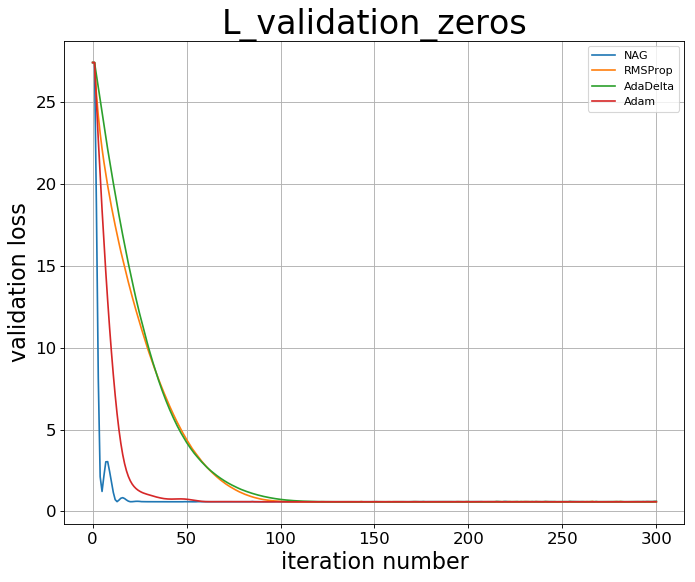

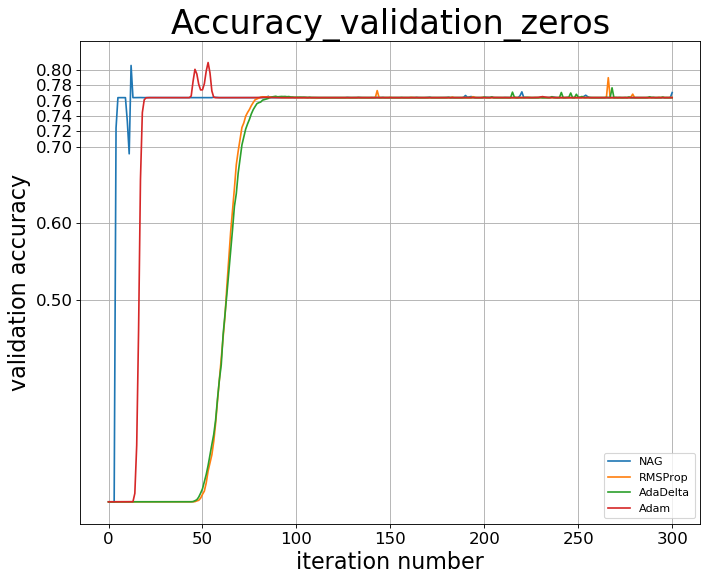

In [13]:
x_train,y_train = dataLoader('D:/a9a.txt')
x_validation,y_validation = dataLoader('D:/a9a.t.txt')
n_features = x_train.shape[1]

it_num = 300
amountOfPoints = 300
para = np.random.random((n_features,1))
para_NAG = copy.copy(para) 
para_RMS = copy.copy(para) 
para_AD = copy.copy(para)
para_Adam = copy.copy(para) 
######################################################################################## 
print('start NAG')
lr_NAG = 0.16
gamma_NAG = 0.9
LR1 = logisticRegression(para_NAG)
nag = NAG(lr_NAG ,gamma_NAG)
it_nag,v_loss_nag,v_accur_nag = optimizier(nag,LR1,x_train,y_train,x_validation,y_validation,it_num,amountOfPoints,64)
######################################################################################## 
print('start RMSProp')
lr_RMS = 0.08
gamma_RMS = 0.9
eposilon_RMS = 1e-8
LR2 = logisticRegression(para_RMS)
rms = RMSProp(lr_RMS,gamma_RMS,eposilon_RMS)
it_rms,v_loss_rms,v_accur_rms = optimizier(rms,LR2,x_train,y_train,x_validation,y_validation,it_num,amountOfPoints,64)
######################################################################################## 
print('start AdaDelta')
gamma_AD = 0.9
eposilon_AD = 1e-3
LR3 = logisticRegression(para_AD)
ad = AdaDelta(gamma_AD,eposilon_AD)
it_ad,v_loss_ad,v_accur_ad = optimizier(ad,LR3,x_train,y_train,x_validation,y_validation,it_num,amountOfPoints,64)
######################################################################################## 
print('start Adam')
lr_Ad = 0.32
gamma_Ad = 0.999
beta_Ad = 0.9
eposilon_Ad = 1e-8
LR4 = logisticRegression(para_Adam)
adam = Adam(lr_Ad,gamma_Ad,beta_Ad,eposilon_Ad)
it_adam,v_loss_adam,v_accur_adam = optimizier(adam,LR4,x_train,y_train,x_validation,y_validation,it_num,amountOfPoints,64)
######################################################################################## 
print('drawing,please wait')
LRloss = [0.6,0.7,0.8,0.9,1]
LRAccur = [0,0.1,0.5,0.6,0.7,0.72,0.74,0.76,0.78,0.8]


plt.figure(figsize=(10,8), dpi=80)
plt.grid(True)
plt.title( 'L_validation_zeros', fontsize=30 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel( 'iteration number', fontsize=20 )
plt.ylabel( 'validation loss', fontsize=20 )
plt.plot( it_nag,v_loss_nag, label='NAG' )
plt.plot( it_rms,v_loss_rms, label='RMSProp' )  
plt.plot( it_ad,v_loss_ad, label='AdaDelta' ) 
plt.plot( it_adam,v_loss_adam, label='Adam' )  
plt.legend()

plt.figure(figsize=(10,8), dpi=80)
plt.grid(True)
plt.title( 'Accuracy_validation_zeros', fontsize=30 )
plt.xticks(fontsize=15)
plt.yticks(LRAccur,fontsize=15)
plt.xlabel( 'iteration number', fontsize=20 )
plt.ylabel( 'validation accuracy', fontsize=20 )
plt.plot( it_nag,v_accur_nag, label='NAG')
plt.plot( it_rms,v_accur_rms, label='RMSProp' )  
plt.plot( it_ad,v_accur_ad, label='AdaDelta' )  
plt.plot( it_adam,v_accur_adam, label='Adam' )  
plt.legend()
#------------------------------------------------------------------------------


print('the last accuracy')
print(accuracy(x_validation,y_validation,LR1.parameter))
print(accuracy(x_validation,y_validation,LR2.parameter))
print(accuracy(x_validation,y_validation,LR3.parameter))
print(accuracy(x_validation,y_validation,LR4.parameter))

plt.show()